# 可视化地图
风格与logger兼容

In [30]:
# 导入必要的库
import yaml
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

def read_yaml(file_path):
    """
    读取YAML文件并返回其内容
    
    参数:
        file_path: YAML文件的路径
    
    返回:
        解析后的YAML数据
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        data = yaml.load(file, Loader=yaml.FullLoader)
    return data

def visualize_map(data, figsize=(15, 10), show_grid=True, show_agents=True, show_tasks=True, show_endpoints=True):
    """
    可视化MAPD问题的地图
    
    参数:
        data: 从YAML文件读取的数据
        figsize: 图像大小
        show_grid: 是否显示网格线
        show_agents: 是否显示代理
        show_tasks: 是否显示任务
        show_endpoints: 是否显示non_task_endpoints
    """
    # 创建图表
    fig, ax = plt.subplots(figsize=figsize)
    
    # 地图尺寸
    width, height = data['map']['dimensions']
    
    # 设置图表边界
    ax.set_xlim(-0.5, width - 0.5)
    ax.set_ylim(-0.5, height - 0.5)
    
    # 绘制网格线
    if show_grid:
        for x in range(width):
            ax.axvline(x=x - 0.5, color='gray', linestyle='-', linewidth=0.8, alpha=0.3)
        for y in range(height):
            ax.axhline(y=y - 0.5, color='gray', linestyle='-', linewidth=0.8, alpha=0.3)
    
    # 设置网格刻度
    ax.set_xticks(range(width))
    ax.set_yticks(range(height))
    
    # 显示刻度标签
    ax.set_xticklabels(range(width))
    ax.set_yticklabels(range(height))
    
    # 绘制障碍物
    obstacles = data['map']['obstacles']
    for obs in obstacles:
        ax.add_patch(Rectangle((obs[0] - 0.5, obs[1] - 0.5), 1, 1, color='black'))
    
    # 绘制基站
    base_points = data['map']['base_points']
    for base_pos in base_points:
        ax.add_patch(Rectangle((base_pos[0] - 0.5, base_pos[1] - 0.5), 1, 1, color='lightblue', alpha=0.7))
    
    # 绘制non_task_endpoints (等待点)
    if show_endpoints and 'non_task_endpoints' in data['map']:
        endpoints = data['map']['non_task_endpoints']
        for ep_pos in endpoints:
            ax.add_patch(Rectangle((ep_pos[0] - 0.5, ep_pos[1] - 0.5), 1, 1, 
                                 color='lightgreen', alpha=0.5, edgecolor='green', linewidth=1))
    
    # 绘制代理
    if show_agents:
        agents = data['agents']
        colors = plt.cm.rainbow(np.linspace(0, 1, len(agents)))
        for i, agent in enumerate(agents):
            start = agent['start']
            ax.scatter(start[0], start[1], s=100, color=colors[i], 
                      label=f"{agent['name']} (容量: {agent['capacity']})")
            ax.text(start[0], start[1] + 0.2, agent['name'], ha='center', fontsize=8)
    
    # 绘制任务
    if show_tasks and 'tasks' in data:
        tasks = data['tasks']
        # 只显示前10个任务，避免图表太乱
        display_tasks = tasks[:10]
        
        # 绘制起点（三角形）
        starts = [task['start'] for task in display_tasks]
        ax.scatter([s[0] for s in starts], [s[1] for s in starts], 
                  marker='^', s=80, color='yellow', edgecolor='black', alpha=0.8, label='任务起点')
        
        # 绘制终点（菱形）
        goals = [task['goal'] for task in display_tasks]
        ax.scatter([g[0] for g in goals], [g[1] for g in goals], 
                  marker='D', s=80, color='green', edgecolor='black', alpha=0.8, label='任务终点')
        
        # 为前10个任务添加任务名
        for i, task in enumerate(display_tasks):
            start = task['start']
            goal = task['goal']
            ax.text(start[0], start[1] - 0.2, task['task_name'], fontsize=7, ha='center')
            # 绘制从起点到终点的虚线箭头
            ax.annotate("", xy=(goal[0], goal[1]), xytext=(start[0], start[1]),
                       arrowprops=dict(arrowstyle="->", linestyle="--", color="gray", alpha=0.4))
    
    # 添加标题和图例
    ax.set_title('MAPD 问题地图可视化')
    ax.set_xlabel('X 坐标')
    ax.set_ylabel('Y 坐标')
    
    # 创建图例
    legend_elements = [
        Rectangle((0, 0), 1, 1, color='black', label='障碍物'),
        Rectangle((0, 0), 1, 1, color='lightblue', alpha=0.7, label='基站'),
    ]
    
    if show_endpoints and 'non_task_endpoints' in data['map']:
        legend_elements.append(
            Rectangle((0, 0), 1, 1, color='lightgreen', alpha=0.5, 
                     edgecolor='green', linewidth=1, label='等待点')
        )
    
    if show_tasks:
        legend_elements.extend([
            Line2D([0], [0], marker='^', color='w', markerfacecolor='yellow', 
                   markersize=10, label='任务起点'),
            Line2D([0], [0], marker='D', color='w', markerfacecolor='green', 
                   markersize=10, label='任务终点')
        ])
    
    # 将图例放置在图外右侧
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    return fig, ax

def visualize_task_distribution(data):
    """
    可视化任务的时间和空间分布
    """
    if 'tasks' not in data:
        print("没有找到任务数据")
        return
    
    tasks = data['tasks']
    
    # 按开始时间分组的任务数量
    start_times = [task['start_time'] for task in tasks]
    unique_times = sorted(set(start_times))
    time_counts = [start_times.count(t) for t in unique_times]
    
    # 创建图表
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 绘制任务开始时间分布
    ax1.bar(unique_times, time_counts, color='royalblue')
    ax1.set_xlabel('任务开始时间')
    ax1.set_ylabel('任务数量')
    ax1.set_title('任务开始时间分布')
    ax1.grid(axis='y', alpha=0.3)
    
    # 用热图显示任务起点分布
    width, height = data['map']['dimensions']
    heatmap = np.zeros((height, width))
    
    for task in tasks:
        start = task['start']
        # 确保坐标在地图范围内
        if 0 <= start[0] < width and 0 <= start[1] < height:
            heatmap[start[1], start[0]] += 1
    
    im = ax2.imshow(heatmap, cmap='YlOrRd', interpolation='nearest')
    ax2.set_title('任务起点空间分布热图')
    ax2.set_xlabel('X 坐标')
    ax2.set_ylabel('Y 坐标')
    fig.colorbar(im, ax=ax2, label='任务数量')
    
    plt.tight_layout()
    return fig

地图尺寸: (36, 20)
代理数量: 10
任务数量: 100
障碍物数量: 50
基站数量: 15


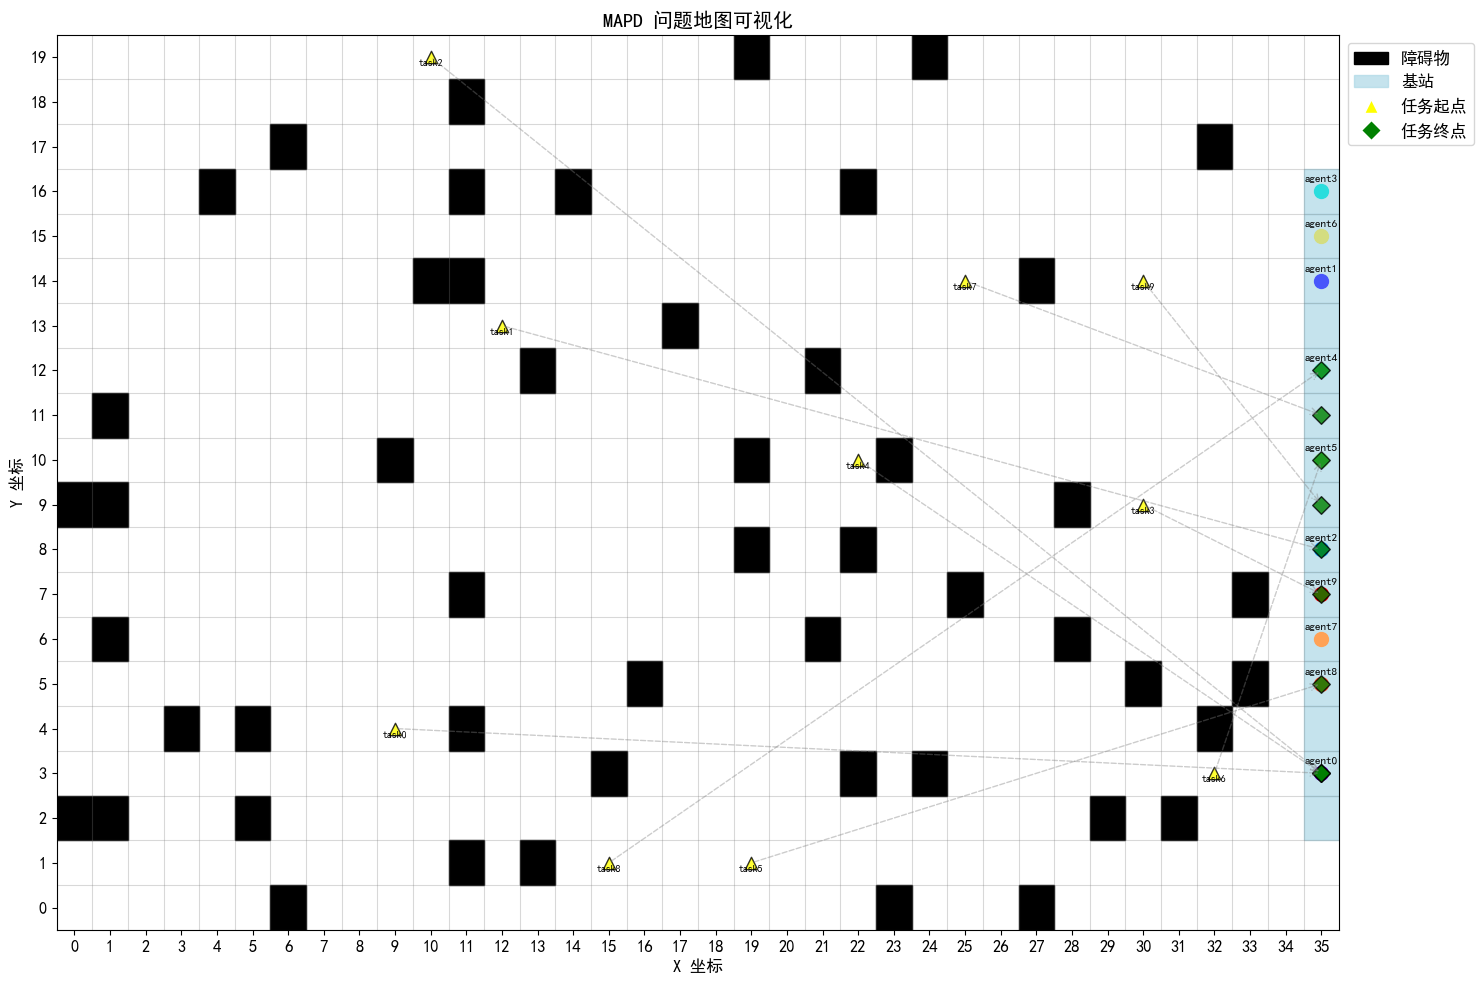

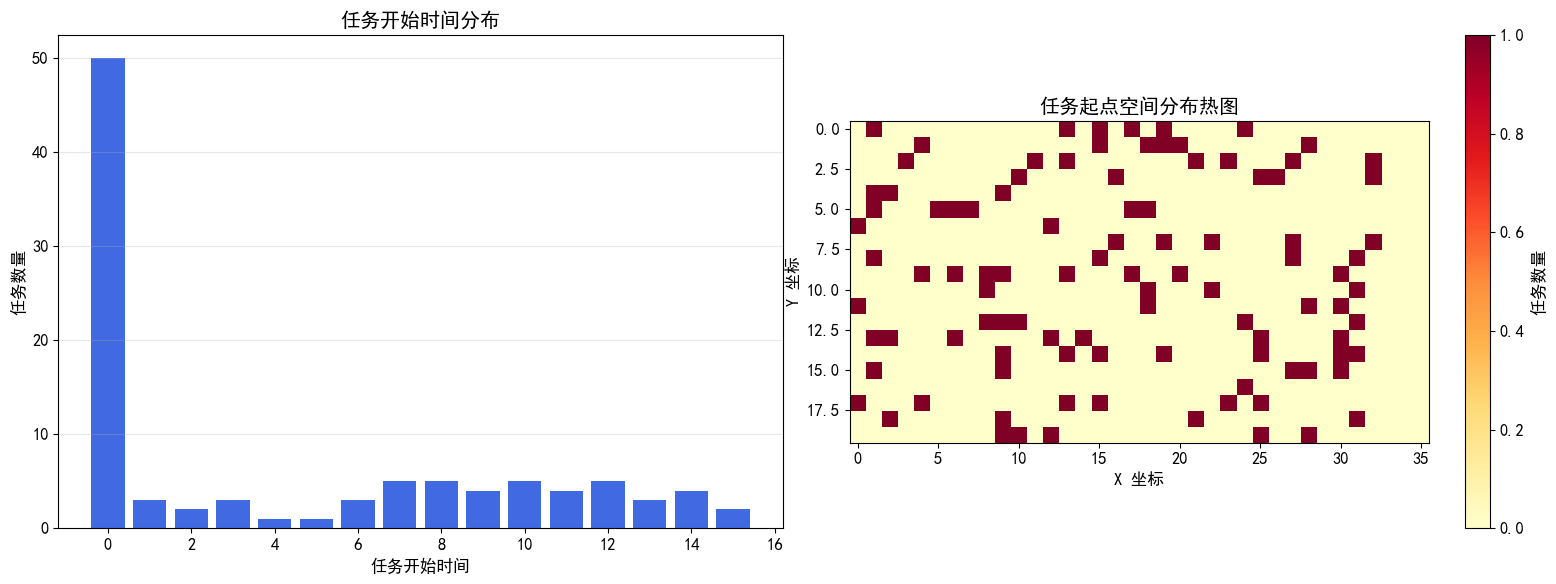

In [31]:
# 中文支持

import matplotlib
# 设置matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'KaiTi', 'FangSong']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12

# 加载并可视化input_mid.yaml文件
yaml_path = r"D:\berker\graduation_design\code\POMAPD\envr10_t100_w36_h20.yaml"
data = read_yaml(yaml_path)

print(f"地图尺寸: {data['map']['dimensions']}")
print(f"代理数量: {len(data['agents'])}")
print(f"任务数量: {len(data['tasks'])}")
print(f"障碍物数量: {len(data['map']['obstacles'])}")
print(f"基站数量: {len(data['map']['base_points'])}")

# 可视化地图
fig, ax = visualize_map(data)
plt.show()

# 可视化任务分布
task_fig = visualize_task_distribution(data)
plt.show()


=== 地图拓扑分析 ===
连通区域数量: 1
最大连通区域大小: 670
死胡同数量: 0
走廊数量: 35
交叉口数量: 635


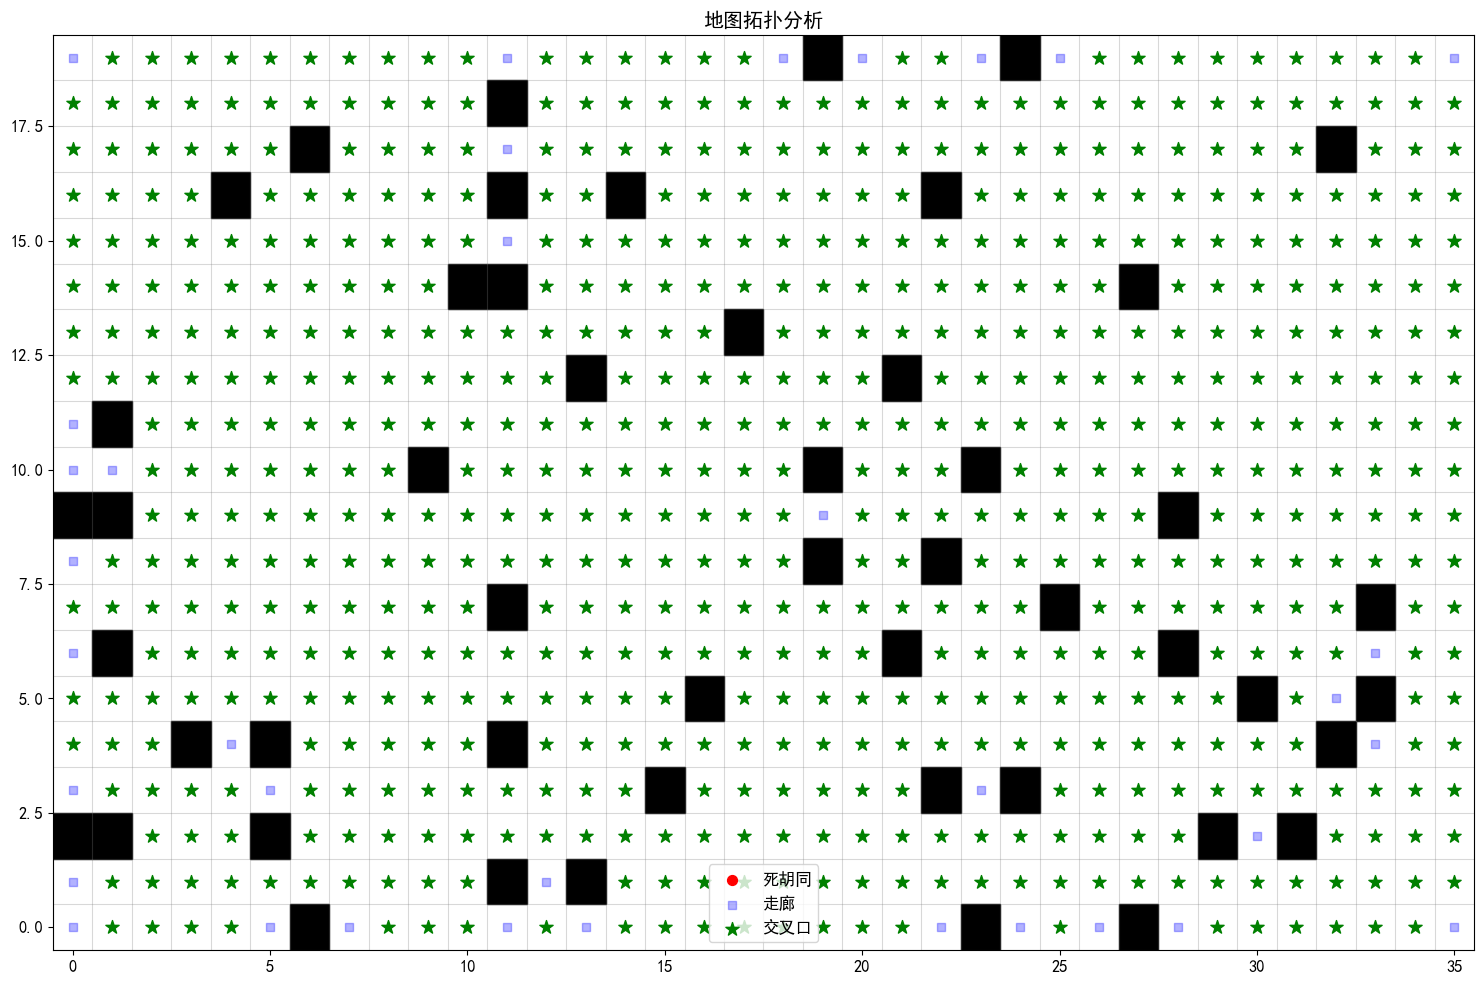

In [32]:
def analyze_map_topology(data):
    """
    分析地图的拓扑结构，包括通道、死胡同等
    """
    import networkx as nx
    
    width, height = data['map']['dimensions']
    obstacles = data['map']['obstacles']
    
    # 创建网格图
    G = nx.grid_2d_graph(width, height)
    
    # 移除障碍物
    for obs in obstacles:
        if G.has_node(obs):
            G.remove_node(obs)
    
    # 检查连通分量
    components = list(nx.connected_components(G))
    
    # 计算节点的度数 - 识别死胡同和通道
    dead_ends = [node for node, degree in G.degree() if degree == 1]
    corridors = [node for node, degree in G.degree() if degree == 2]
    junctions = [node for node, degree in G.degree() if degree > 2]
    
    # 打印结果
    print("\n=== 地图拓扑分析 ===")
    print(f"连通区域数量: {len(components)}")
    print(f"最大连通区域大小: {len(max(components, key=len))}")
    print(f"死胡同数量: {len(dead_ends)}")
    print(f"走廊数量: {len(corridors)}")
    print(f"交叉口数量: {len(junctions)}")
    
    # 可视化
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # 绘制网格和障碍物
    for x in range(width):
        ax.axvline(x=x - 0.5, color='gray', linestyle='-', linewidth=0.8, alpha=0.3)
    for y in range(height):
        ax.axhline(y=y - 0.5, color='gray', linestyle='-', linewidth=0.8, alpha=0.3)
        
    # 绘制障碍物
    for obs in obstacles:
        ax.add_patch(Rectangle((obs[0] - 0.5, obs[1] - 0.5), 1, 1, color='black'))
    
    # 绘制死胡同、走廊和交叉口
    ax.scatter([n[0] for n in dead_ends], [n[1] for n in dead_ends], 
              color='red', marker='o', s=50, label='死胡同')
    ax.scatter([n[0] for n in corridors], [n[1] for n in corridors], 
              color='blue', marker='s', s=30, alpha=0.3, label='走廊')
    ax.scatter([n[0] for n in junctions], [n[1] for n in junctions], 
              color='green', marker='*', s=100, label='交叉口')
    
    ax.set_title('地图拓扑分析')
    ax.set_xlim(-0.5, width - 0.5)
    ax.set_ylim(-0.5, height - 0.5)
    ax.legend()
    
    plt.tight_layout()
    return fig, ax, G

# 进行地图拓扑分析
topology_fig, topology_ax, graph = analyze_map_topology(data)
plt.show()